In [42]:
from quantopian.interactive.data.sentdex import sentiment
from quantopian.pipeline.filters.morningstar import Q1500US

In [43]:
AAPL = symbols("AAPL").sid
AAPL_sentiment = sentiment[sentiment.sid==AAPL]

In [44]:
AAPL_sentiment.peek()

,symbol,sentiment_signal,sid,asof_date,timestamp
0,AAPL,6.0,24,2012-10-15,2012-10-16
1,AAPL,2.0,24,2012-10-16,2012-10-17
2,AAPL,6.0,24,2012-10-17,2012-10-18
3,AAPL,6.0,24,2012-10-18,2012-10-19
4,AAPL,6.0,24,2012-10-19,2012-10-20
5,AAPL,6.0,24,2012-10-20,2012-10-21
6,AAPL,1.0,24,2012-10-21,2012-10-22
7,AAPL,-1.0,24,2012-10-22,2012-10-23
8,AAPL,-3.0,24,2012-10-23,2012-10-24
9,AAPL,-1.0,24,2012-10-24,2012-10-25


In [45]:
import blaze

Convert the data frame from a blaze data frame to a pandas data frame

In [46]:
AAPL_sentiment = blaze.compute(AAPL_sentiment)

In [47]:
type(AAPL_sentiment)

<class 'pandas.core.frame.DataFrame'>

Chaning the index so it's easier to make a time series. Inplace means do we want to create a new dataframe (new object) or change just change the current one. True does not create a new object; default is false.

In [48]:
AAPL_sentiment.set_index("asof_date", inplace=True)

In [53]:
AAPL_sentiment.head()

,symbol,sentiment_signal,sid,timestamp
asof_date,,,,
2012-10-15,AAPL,6.0,24,2012-10-16
2012-10-16,AAPL,2.0,24,2012-10-17
2012-10-17,AAPL,6.0,24,2012-10-18
2012-10-18,AAPL,6.0,24,2012-10-19
2012-10-19,AAPL,6.0,24,2012-10-20


Plot representing the sentiment over 5+ years. Signals can be noisy initally because it's based of simple moving averages so it takes time to be more smooth.

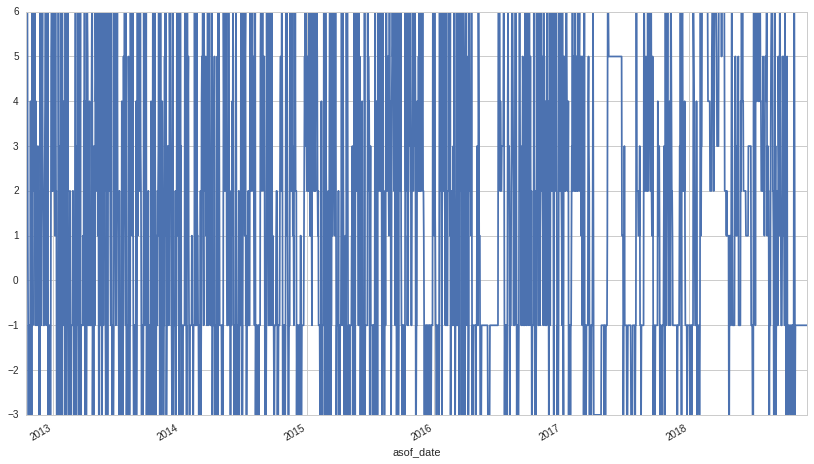

In [52]:
AAPL_sentiment["sentiment_signal"].plot()

In [54]:
AAPL_sentiment = AAPL_sentiment[(AAPL_sentiment.index > "2018.01.01")]

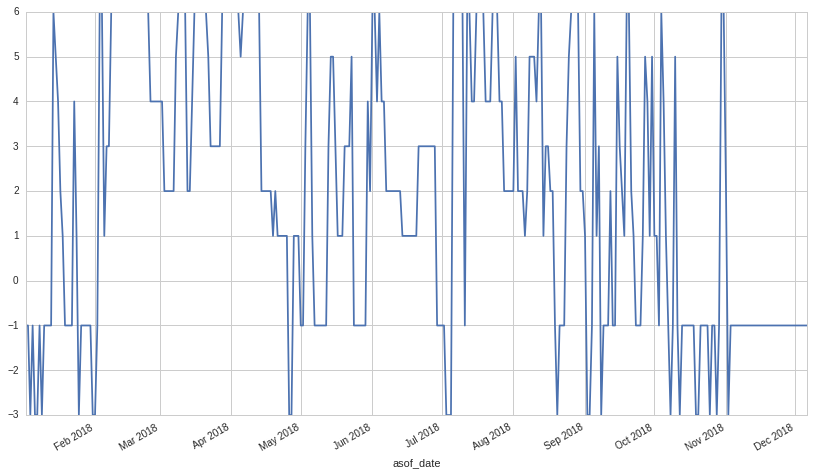

In [55]:
AAPL_sentiment["sentiment_signal"].plot()

In [59]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [60]:
def make_pipeline():
    return Pipeline()

In [61]:
result = run_pipeline(make_pipeline(), start_date = "2018.01.01", end_date = "2018.01.01")

In [62]:
type(result)

<class 'pandas.core.frame.DataFrame'>

We need to import sentiment from pipeline because before we were importing from interactive and that is a blaze expression but we want it as a pandas expression

In [71]:
from quantopian.pipeline.data.sentdex import sentiment

In [72]:
def make_pipeline():
    sentiment_factor = sentiment.sentiment_signal.latest
    
    universe = (Q1500US() & sentiment_factor.notnull())
    
    sentiment_pipeline = Pipeline(columns={"sentiment": sentiment_factor,
                                  "longs": (sentiment_factor > 2),
                                  "shorts": (sentiment_factor < -4)},
                                  screen = universe)
    
    return sentiment_pipeline

In [73]:
result = run_pipeline(make_pipeline(), start_date = "2015.01.01", end_date = "2016.01.01")

In [80]:
result.head()

longs  sentiment shorts
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])   False        2.0  False
                          Equity(24 [AAPL])  False        2.0  False
                          Equity(62 [ABT])   False        1.0  False
                          Equity(67 [ADSK])   True        6.0  False
                          Equity(76 [TAP])   False       -3.0  False

Now that we have run our pipeline, we want to know which assets are in it, aka those those in the Q1500US and that we have sentiment results for. That's what we are doing below.

In [81]:
assets = result.index.levels[1].unique()
len(assets)

524

Here we want the pricing info for our assets over the time frame. We change the dates forward a month and back a month because we alphalens computes the alpha using some data from before the start along with after the end dates

In [82]:
pricing = get_pricing(assets, start_date = "2014.12.01", end_date = "2016.02.01", fields= "open_price" )

In [95]:
import alphalens
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = result["sentiment"],
                                                       prices = pricing,
                                                       quantiles = 2,
                                                       periods = (1,5,10))

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [97]:
factor_data.head()

1D        5D       10D  \
date                      asset                                             
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.014515  0.010059 -0.057359   
                          Equity(24 [AAPL]) -0.027830  0.011495 -0.039142   
                          Equity(62 [ABT])  -0.009947  0.011060 -0.026912   
                          Equity(67 [ADSK]) -0.015152 -0.021312 -0.074426   
                          Equity(76 [TAP])  -0.016752  0.045275 -0.005899   

                                             factor  factor_quantile  
date                      asset                                       
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])      2.0                2  
                          Equity(24 [AAPL])     2.0                2  
                          Equity(62 [ABT])      1.0                1  
                          Equity(67 [ADSK])     6.0                2  
                          Equity(76 [TAP])     -3.0                1

Returns Analysis


,1D,5D,10D
Ann. alpha,0.015,0.024,0.022
beta,-0.006,-0.030,-0.042
Mean Period Wise Return Top Quantile (bps),0.736,1.055,1.091
Mean Period Wise Return Bottom Quantile (bps),-0.371,-0.534,-0.533
Mean Period Wise Spread (bps),1.106,1.584,1.618


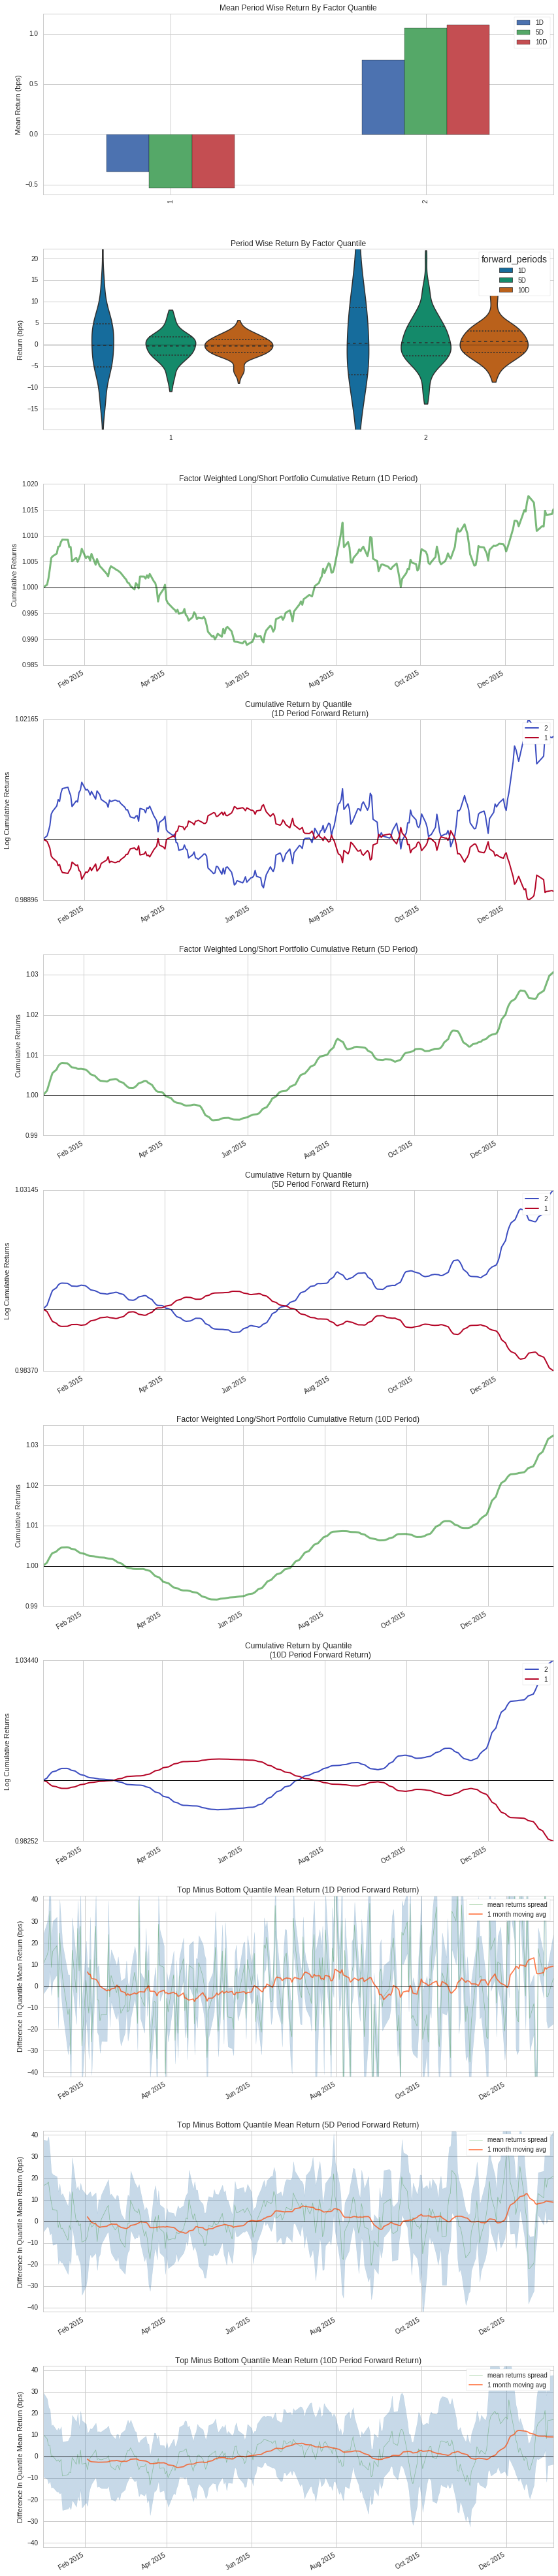

In [98]:
alphalens.tears.create_returns_tear_sheet(factor_data)

We see that the SD of our returns is huge independant of the quartile which is really bad. Even if the mean return for the 2nd quartile is better, the SD is really bad.